<a href="https://colab.research.google.com/github/Yutong-Lu/CHL5230FinalProject/blob/main/KNN_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as  sns
import plotly.express as px
import numpy as np
import warnings
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import RocCurveDisplay, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

In [3]:
# load the data
data = pd.read_excel('Diabetes Study File 10K Dec 14 2017.xlsx')

In [10]:
# Count the number of missing values (NaN or None) in each column of the 'data' DataFrame
missing_value_counts = data.isnull().sum()
missing_value_counts

Age_at_Exam                                   0
sBP                                           4
sBP_Date                                      0
BMI                                           0
BMI_Date                                      0
LDL                                          61
LDL_Date                                      0
HDL                                          72
HDL_Date                                     64
A1c                                           0
A1c_Date                                      0
TG                                           53
TG_Date                                      42
FBS                                           0
FBS_Date                                      0
FBS>DM                                        0
Total_Cholesterol                           207
Total_Cholesterol_Lab_Date                  197
Diabetes                                      0
DM_OnsetDate                               4863
Depression                              

# Data Cleaning & Exploration

In [5]:
# Replace categorical values with numerical equivalents
data['DIABETES'].replace({'Yes' : 1, 'No' : 0}, inplace=True)
data['Sex'].replace({'Female' : 1, 'Male' : 0}, inplace=True)

In [22]:
# Create indicator for using hypertension meds/corticosteroid
data['Use_of_Hypertension_Medications'] = data['Hypertension_Medications'].notnull().astype('int')
data['Use_of_Corticosteroids'] = data['Corticosteroids'].notnull().astype('int')

In [24]:
# Create a subset with no date
df = data[['Age_at_Exam', 'sBP', 'BMI', 'LDL', 'HDL', 'A1c', 'TG', 'FBS', 'Total_Cholesterol', 'Depression',
     'HTN', 'OA', 'COPD', 'Use_of_Hypertension_Medications', 'Use_of_Corticosteroids', 'Sex', 'DIABETES']]

In [25]:
print(df.shape)

(10000, 17)


In [26]:
# Count the number of missing values (NaN or None) in each column of the 'df' DataFrame
missing_value_counts = df.isnull().sum()
missing_value_counts

Age_at_Exam                          0
sBP                                  4
BMI                                  0
LDL                                 61
HDL                                 72
A1c                                  0
TG                                  53
FBS                                  0
Total_Cholesterol                  207
Depression                           0
HTN                                  0
OA                                   0
COPD                                 0
Use_of_Hypertension_Medications      0
Use_of_Corticosteroids               0
Sex                                  0
DIABETES                             0
dtype: int64

In [29]:
# Calculate the percentage of rows with one or more missing values in "df" dataframe
percentage_missing_rows = (df.isnull().sum(axis=1) > 0).sum() / len(df)
percentage_missing_rows
# 4% of missing data (rows) after removing dates - ideal and can either remove or use MAR to impute

0.0356

In [30]:
#Distribution of Classes "Diabetes"
import plotly.express as px
import pandas as pd


counts = df['DIABETES'].value_counts()

# Define your color sequence
colors = ['#1c3a73', '#7cb1c2']

fig = px.pie(
    names=counts.index,
    values=counts.values,
    hole=0.5,  # size of the hole, 0.5 means 50%
    title='Distribution of Classes in "Diabetes"',
    color_discrete_sequence=colors  # apply your colors here
)

# Update layout for better appearance
fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0),  # Adjust top margin to make room for title
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.5,
        xanchor="left",
        x=1.05,
        title='Class/ASD'
    ),
    title=dict(
        text='Distribution of Classes in "Class/ASD"',
        x=0.45,  # Centering the title
        xanchor='center',
        y=0.95,  # Adjusting y position to place title above chart
        yanchor='top',
        font=dict(size=16)
    ),
    width=500,
    height=350
)

fig.show()

# Class is balanced - checked and expected

In [ ]:
# create list of numerical, categorical, multinomial features
target_column = 'DIABETES'
categorical_columns = ['Depression', 'HTN', 'Use_of_Hypertension_Medications', 'Use_of_Corticosteroids', 'Sex','OA', 'COPD']
numerical_columns = ['Age_at_Exam', 'sBP', 'BMI', 'LDL', 'HDL', 'A1c', 'TG', 'FBS', 'Total_Cholesterol']
df.head()

In [ ]:
# checking the difference in distribution of numerical features in two classes

# Create a grid of subplots with 2 rows and 3 columns
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(12, 8))

# Loop over each feature in numerical and multinomial lists
for i, column in enumerate(numerical_columns):
    # Calculate the position for the subplot; x is the row index and y is the column index
    x = i // 3
    y = i % 3

    # Plot a histogram of the feature split by the 'target' class
    # kde=True adds a Kernel Density Estimate plot to smooth the histogram, providing a clearer view of the data distribution
    sns.histplot(df, x=column, hue='DIABETES', kde=True, palette='rocket', ax=axs[x][y])

# Display all the subplots
plt.show()

In [ ]:
# Checking the difference in the distribution of categorical features across two classes

# Initialize a 3x3 grid of subplots
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

# Loop through each categorical column to plot its distribution
for i, column in enumerate(categorical_columns):
    # Determine the subplot's position based on the current index
    x = i // 3
    y = i % 3

    # Create a count plot for the current column
    # The hue parameter divides the counts based on the 'target' column,
    # allowing for a comparison between the classes.
    sns.countplot(data=df, x=column, hue='DIABETES', palette='rocket', ax=axs[x][y])

# Display all the plots
plt.show()

In [ ]:
# #Visualization - boxplot - depression
# # Define a custom color palette
# custom_palette = ['#0d7fa3','#c4336d']

# # Create the boxplot with the custom color palette
# plt.figure(figsize=(8, 6))
# sns.boxplot(data=df, x='DIABETES', y='Age_at_Exam', hue='Sex', palette=custom_palette)

# # Set labels and title
# plt.xlabel('DIABETES')
# plt.ylabel('Age')
# plt.title('Distribution of Age by Diabetes and Sex')

# # Show the plot
# plt.show()

In [ ]:
# # Visualization - Age distirbution
# plt.figure(figsize=(6, 5))
# sns.violinplot(x="Sex", y="Age_at_Exam", hue="DIABETES", data=df, split=True, palette=['#1c3a73', '#7cb1c2'])
# plt.title('DIABETES and Age vs Sex')
# plt.yticks(range(0, 110, 10))
# plt.show()

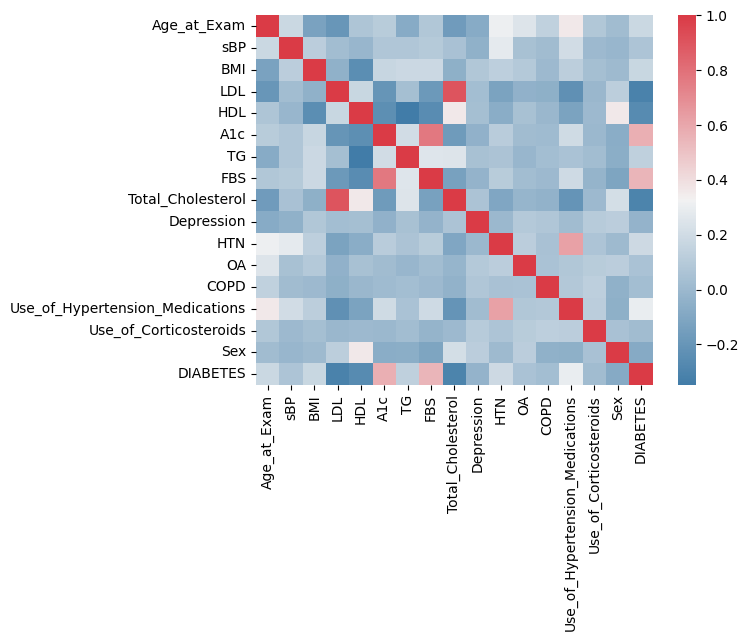

In [38]:
# Correlation Heatmap
df_corr = df.corr()
cmap = sns.diverging_palette(240, 10, as_cmap=True) # customerize cmap color
sns.heatmap(df_corr, annot=False, cmap=cmap)
plt.show()

# A1C, FBS - moderte to strong correlations with diabetes; A1C & FBS has strong correlation
# total cholesterol & LDL has strong correlation
# HTN and use of hypertension medications has moderate correlation

#KNN

In [44]:
# Split the data into features and label
# eliminate:'Use_of_Hypertension_Medications', "A1C", "Total_Cholesterol"
X = df[['Age_at_Exam', 'sBP', 'BMI',  'HDL','TG', 'FBS', 'LDL', 'Depression',
     'HTN', 'OA', 'COPD','Use_of_Corticosteroids', 'Sex', 'DIABETES']]
y = df[['DIABETES']]

In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Scale the features/normalizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
# Imputation on missing values in "LDL", "HDL","TG", "sBP"
imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_filled_mice = imputer.fit_transform(X_train)
X_test_filled_mice = imputer.fit_transform(X_test)

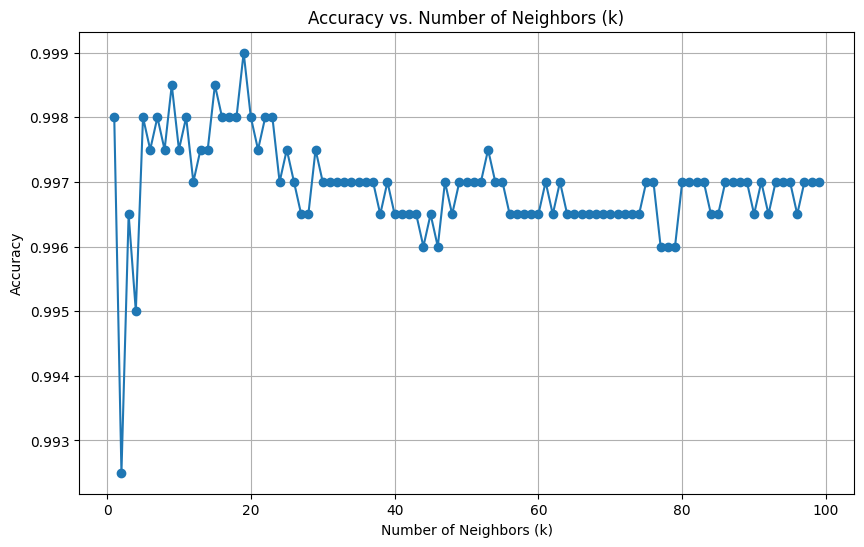

In [48]:
# Apply KNN

# Selecting k
k_values = []
accuracy_values = []
best_k = 0
max_acc = 0

for k in range(1, 100):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train_filled_mice, y_train)
    y_pred = knn_classifier.predict(X_test_filled_mice)
    accuracy = accuracy_score(y_test, y_pred)
    k_values.append(k)
    accuracy_values.append(accuracy)
    if accuracy > max_acc:
        max_acc = accuracy
        best_k = k


plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_values, marker='o')
plt.title("Accuracy vs. Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

Text(0, 0.5, 'Accuracy Score')

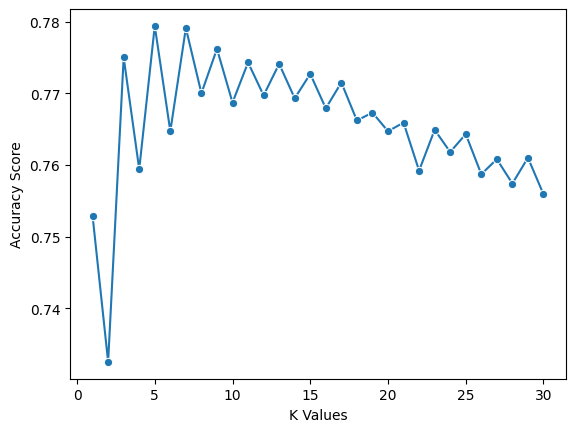

In [49]:
# Find the best K using Cross Validation

from sklearn.model_selection import cross_val_score

# Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
X = imputer.fit_transform(X)

k_values = [i for i in range (1,31)]
scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [61]:
# Apply the KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_filled_mice, y_train)

y_pred = knn.predict(X_test_filled_mice)

In [65]:
# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# overfitting??

[[ 979    0]
 [   4 1017]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       979
           1       1.00      1.00      1.00      1021

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



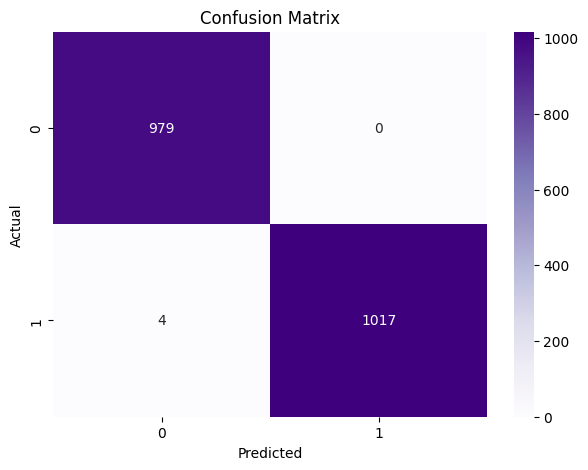

In [64]:
#Visualization of KNN Results Using a Confusion Matrix Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique classes
classes = df['DIABETES'].unique()

# Plotting the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred, labels=classes), cmap='Purples', annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()